In [1]:
from src.SensitivityAnalysis import load_data
import matplotlib.pyplot as plt
import pandas as pd
from src.SugarScape import SugarScape
from mesa import batch_run
import numpy as np

# Finding Parameters

In [2]:
data = load_data()
averaged = []
for i in range(len(data) // 10 - 1):
    trader_mean = data['Trader Count'].iloc[i*10:(i+1)*10].mean()
    gini_mean = data['Gini'].iloc[i*10:(i+1)*10].mean()
    
    if trader_mean > 0:
        averaged.append(1 / gini_mean * trader_mean)


In [3]:
# Find where gini maximized 
worst = dict(data.iloc[np.argmin(averaged)])
best = dict(data.iloc[np.argmax(averaged)])

worst = {key: float(value) for (key,value) in worst.items()}
best = {key: float(value) for (key,value) in best.items()}

print(f'Worst case: {worst}')
print(f'Best case: {best}')

# Find closest to average
dist = (averaged - np.mean(averaged))**2
idx = np.argmin(dist)

typical = dict(data.iloc[idx * 10])
typical = {key: float(value) for (key,value) in typical.items()}
print(f'Typical: {typical}')


Worst case: {'vision_mean': 3.53318753093481, 'metabolism_mean': 5.998808294534683, 'max_age_mean': 85.80413511954248, 'repopulate_factor': 14.66142563149333, 'cell_regeneration': 4.503312561661005, 'Gini': 0.423359972362048, 'Trader Count': 1104.0}
Best case: {'vision_mean': 1.7622311217710376, 'metabolism_mean': 5.248785311356187, 'max_age_mean': 85.99956788122654, 'repopulate_factor': 14.353867815807462, 'cell_regeneration': 1.2028064504265783, 'Gini': 0.4930405445705637, 'Trader Count': 437.0}
Typical: {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 96.730439318344, 'repopulate_factor': 12.009924734011292, 'cell_regeneration': 1.5217601098120213, 'Gini': 0.50072101795512, 'Trader Count': 1118.0}


# Run Base Simulations

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

ValueError: need at least one array to concatenate

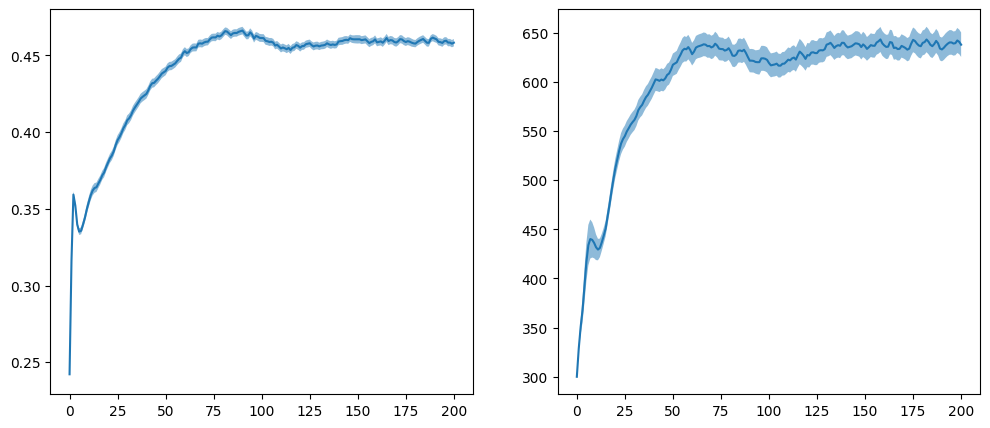

In [4]:
## USe these map schemes based on your name
# Priyank: top-heavy
# Amish: uniform
# Ilia: split

map_scheme = 'top_heavy'

scenarios = [
    {'vision_mean': 4.264199728146195, 'metabolism_mean': 6.751366691663861, 'max_age_mean': 96.55008263885976,
     'repopulate_factor': 7.485186895355582, 'cell_regeneration': 1.6743798777461052, 'map_scheme': map_scheme},   # Worst case
    
    {'vision_mean': 2.571960593573749, 'metabolism_mean': 7.285224918276071, 'max_age_mean': 93.18476642481984,
     'repopulate_factor': 5.733334645628929, 'cell_regeneration': 2.95167014375329, 'map_scheme': map_scheme},     # Best case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 96.730439318344,
     'repopulate_factor': 12.009924734011292, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},  # Average case
    
    {'vision_mean': 3.5, 'metabolism_mean': 6, 'max_age_mean': 85,
     'repopulate_factor': 10, 'cell_regeneration': 3, 'map_scheme': map_scheme},                                   # Balanced case
    
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 70,
     'repopulate_factor': 5, 'cell_regeneration': 1.5217601098120213, 'map_scheme': map_scheme},                    # Slow evolving
    
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 70,
     'repopulate_factor': 15, 'cell_regeneration': 3.368525765836239, 'map_scheme': map_scheme},                    # Fast evolving
]

results = []
replicates = 30
max_steps = 200
for scenario in scenarios:
    batch = batch_run(SugarScape, scenario, number_processes=None,
                      iterations=replicates, max_steps=max_steps, display_progress=True, data_collection_period=1)
    for i in range(replicates):
        scenario["Gini"] = [val['Gini'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]
        scenario["Trader Count"] = [val['Trader Count'] for val in batch[(max_steps+1)*i:(max_steps+1)*(i+1)]]

        results.append(list(scenario.values()))

# Convert to df and save
names = list(scenario.keys()) 
df = pd.DataFrame(results, columns=names)
    
df.to_csv(f'Experiments/Base/results_{map_scheme}.csv')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
names = ['Worst', 'Best', 'Typical', 'Balanced', 'Slow evolving', 'Fast evolving']
for i in range(len(scenarios)):
    # Get gini and trader count of every scenario
    gini = df.iloc[i*max_steps:(i+1)*max_steps]['Gini']
    trader = df.iloc[i*max_steps:(i+1)*max_steps]['Trader Count']
    
    # Convert to 2d np arrays
    gini = np.vstack(gini)
    trader = np.vstack(trader)
    
    # Get means and ci
    gini_mean = np.mean(gini, axis=0)
    gini_ci = np.std(gini, ddof=1, axis=0) / replicates * 1.96
    trader_mean = np.mean(trader, axis=0)
    trader_ci = np.std(trader, ddof=1, axis=0) / replicates * 1.96
    
    # Plotting
    x = np.arange(len(gini_mean))
    ax[0].plot(x, gini_mean, label=names[i])
    ax[0].fill_between(x, gini_mean + gini_ci, gini_mean - gini_ci, alpha=0.5)
    ax[1].plot(x, trader_mean, label=names[i])
    ax[1].fill_between(x, trader_mean + trader_ci, trader_mean - trader_ci, alpha=0.5)

# Set labels, grid and title
ax[1].legend(bbox_to_anchor=(1, 1.05))
ax[0].set_title('Gini')
ax[1].set_title('Trader Count')
for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Timesteps')
ax[0].set_ylabel('Gini Coefficient')
ax[1].set_ylabel('Number of Traders')

# 
fig.tight_layout()
fig.savefig(f'Experiments/Base/plot_{map_scheme}.png', dpi=300, bbox_inches='tight')


In [5]:
print(gini)

Series([], Name: Gini, dtype: object)


In [ ]:
?names = list(scenario.keys()) 
df = pd.DataFrame(results, columns=names)
df.to_csv(f'Base_results_{map_scheme}.csv')